# Sampling
Here we show how to use the emulator in combination with a fast sampler in JAX to obtain posterior contours. We use a subset of the mock data we use in the paper made of only 20 supernovae, so the results will not be conclusive; however, the speed-up is already relevant in this scenario.

In [1]:
import numpy
import jax
import jax.numpy as np
from velocemu.emulator import IntegralEmu
from velocemu.utils import mu_estimator, reconstruct_symmetric_matrix_from_lower_diagonal
import jax.random as jr
from jax.scipy.stats import multivariate_normal
import time
from tqdm import trange
import matplotlib.pyplot as plt
import corner
import pkg_resources

/home/users/p/piras/veloce/velocemu/emulator.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# first we load the data; note this is a subset of the mock used for the paper
# credits to Francesco Sorrenti (https://fsorrenti.github.io/) for the mock generation
# as well as for some scoutpip elements (https://github.com/fsorrenti/scoutpip)

In [3]:
mock_z_path = pkg_resources.resource_filename("velocemu", f"mock_data/mock_z_values.npy")
mock_mu_path = pkg_resources.resource_filename("velocemu", f"mock_data/mock_mu_values.npy")
mock_err_path = pkg_resources.resource_filename("velocemu", f"mock_data/mock_error_covariance.npy")
mock_zzalpha_path = pkg_resources.resource_filename("velocemu", f"mock_data/mock_z_z_alpha.npy")

z_values = numpy.load(mock_z_path).astype(float)
mu_values = numpy.load(mock_mu_path).astype(float)
cephdata = np.zeros_like(mu_values) # there are no cepheids in this dataset
is_caldata = np.zeros_like(mu_values)  # there are no cepheids in this dataset
error_covariance = numpy.load(mock_err_path)
z_z_alpha=numpy.load(mock_zzalpha_path)

In [4]:
# the define the emulator, including its accessory files
integrator = IntegralEmu(z_z_alpha)
unique_rows = numpy.load('./test_unique_rows.npy')
inverse_indices = numpy.load('./test_inverse_indices.npy')
condition = numpy.load('./test_condition.npy')

2025-07-09 01:33:07.188837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Then we define the prior and likelihood for our sampling.

In [5]:
def log_prior(params):
    """
    Compute the log-prior for 3 parameters with uniform priors.
    """
    # Define the parameter ranges for uniform priors
    ranges = np.array([
        (0.1, 0.5),  # Range for Omat
        (50., 100.),    # Range for H0
        (1.5, 4.5),    # Range for lnAs
    ])

    # Compute log-prior for each parameter
    lower_bounds, upper_bounds = ranges[:, 0], ranges[:, 1]
    inside_bounds = (params >= lower_bounds) & (params <= upper_bounds)

    # Use np.where to avoid TracerBoolConversionError
    log_prior_value = np.where(
        np.all(inside_bounds),
        np.sum(-np.log(upper_bounds - lower_bounds)),
        -np.inf
    )

    return log_prior_value


def log_prob_(parameters):
    """The total log-probability, namely the sum of log-prior and log-likelihood"""

    # first compute the prior
    log_prior_value = log_prior(parameters)    
    
    # then the likelihood
    def compute_likelihood(_):
        Omat, H0, lnAs = parameters 
        mu_estimated, prefactor = mu_estimator(z_values, mu_values, cephdata, is_caldata, H0, Omat, dM=0.)
        
        # use the outer product to get the full prefactor matrix
        prefactor_matrix = np.outer(prefactor, prefactor)

        cova = reconstruct_symmetric_matrix_from_lower_diagonal(integrator.predict(np.array([Omat,H0,lnAs]), 
                                                                                   unique_rows, 
                                                                                   inverse_indices, condition,
                                                                                   dim1=20,#np.sum(condition),
                                                                                   dim2=210-20),#np.sum(~condition)), 
                                                                20)

        full_covariance=error_covariance+cova/prefactor_matrix

        log_likelihood = multivariate_normal.logpdf(np.zeros(20), mean=mu_estimated/prefactor, 
                                                    cov=np.array(full_covariance))
    
        return log_prior_value + log_likelihood

    # to make everything compatible with JAX
    return jax.lax.cond(
        log_prior_value > -np.inf,  # Check if prior is valid
        compute_likelihood,      # Compute likelihood if prior is valid
        lambda _: -np.inf,      # Return -inf if prior is invalid
        operand=None,
    )

## Affine
The next two cells are taken directly from the affine sampler; this is essentially a JAX version of `emcee`. Refer to [their repository](https://github.com/justinalsing/affine/tree/jax) if you'd like to know more.

In [6]:
rng = jr.PRNGKey(13)

# Number of walkers (note you'll end up with a total of 2*n_walkers for this parallel variant of the affine sampler)
n_walkers = 10 

# Number of MCMC steps to take (you'll end up with an MCMC chain with shape (n_steps, 2*n_walkers, n_parameters))
n_steps = 1000 # could have to increase or decrease based on complexity of chain

rng, rng1, rng2 = jr.split(rng, 3)

# initialize walkers and current state
minvals = np.array([0.1, 50.,  1.5])
maxvals = np.array([0.5, 100., 4.5])

n_params = len(maxvals)

walkers1 = jr.uniform(rng1, shape=[n_walkers, n_params], minval=minvals, maxval=maxvals)
walkers2 = jr.uniform(rng2, shape=[n_walkers, n_params], minval=minvals, maxval=maxvals)
current_state = [walkers1, walkers2]

In [7]:
uniform_kwargs = {"minval" : 0., "maxval" : 1.}
randint_kwargs = {"minval" : 0, "maxval" : n_walkers}
rng, _ = jr.split(rng)

log_prob_vmap = jax.vmap(log_prob_)

@jax.jit
def single_sample_step(current_state1, current_state2, logp_current1, logp_current2, rng):
    # Split keys for separate random processes in each epoch
    rng, rng_p1, rng_z1, rng_a1, rng_p2, rng_z2, rng_a2 = jr.split(rng, 7)

    # FIRST SET OF WALKERS
    # Proposals
    ix = jr.randint(rng_p1, shape=(n_walkers,), **randint_kwargs)
    partners1 = current_state2[ix]
    z1 = 0.5 * (jr.uniform(rng_z1, shape=(n_walkers,), **uniform_kwargs) + 1.) ** 2.
    proposed_state1 = partners1 + (z1 * (current_state1 - partners1).T).T

    # Target log prob at proposed points
    logp_proposed1 = log_prob_vmap(proposed_state1)#, *args)
    logp_proposed1 = np.where(
        np.isnan(logp_proposed1), 
        np.ones_like(logp_proposed1) * np.log(0.), 
        logp_proposed1)

    # Acceptance probability
    p_accept1 = np.minimum(
        np.ones(n_walkers), 
        z1 ** (n_params - 1.) * np.exp(logp_proposed1 - logp_current1))

    # Accept or not
    accept1 = (jr.uniform(rng_a1, shape=(n_walkers,), **uniform_kwargs) <= p_accept1)

    # Update the state
    current_state1 = (current_state1.T * (1. - accept1) + proposed_state1.T * accept1).T
    logp_current1 = np.where(accept1, logp_proposed1, logp_current1)

    # SECOND SET OF WALKERS

    # Proposals
    ix = jr.randint(rng_p2, shape=(n_walkers,), **randint_kwargs)
    partners2 = current_state1[ix]
    z2 = 0.5 * (jr.uniform(rng_z2, shape=(n_walkers,), **uniform_kwargs) + 1.) ** 2.
    proposed_state2 = partners2 + (z2 * (current_state2 - partners2).T).T

    # Target log prob at proposed points
    logp_proposed2 = log_prob_vmap(proposed_state2)#, *args)
    logp_proposed2 = np.where(
        np.isnan(logp_proposed2), 
        np.ones_like(logp_proposed2) * np.log(0.), 
        logp_proposed2)

    # Acceptance probability
    p_accept2 = np.minimum(
        np.ones(n_walkers), 
        z2 ** (n_params - 1.) * np.exp(logp_proposed2 - logp_current2))

    # Accept or not
    accept2 = (jr.uniform(rng_a2, (n_walkers,), **uniform_kwargs) <= p_accept2)

    # Update the state
    current_state2 = (current_state2.T * (1. - accept2) + proposed_state2.T * accept2).T
    logp_current2 = np.where(accept2, logp_proposed2, logp_current2)
    return current_state1, current_state2, logp_current1, logp_current2, rng
        
def sample(rng, n_steps, current_state, progressbar=True):
    
    # Split the current state (should be of shape (n_walkers, 2))
    current_state1, current_state2 = current_state
    
    # Pull out the number of parameters and walkers
    n_walkers, n_params = current_state1.shape

    # Initial target log prob for the walkers (and set any nans to -inf)...
    logp_current1 = log_prob_vmap(current_state1)
    logp_current2 = log_prob_vmap(current_state2)

    logp_current1 = np.where(
        np.isnan(logp_current1),
        np.ones_like(logp_current1) * np.log(0.), # = -inf
        logp_current1)
    logp_current2 = np.where(
        np.isnan(logp_current2), 
        np.ones_like(logp_current2) * np.log(0.), 
        logp_current2)

    # Holder for the whole chain
    chain = [np.concatenate([current_state1, current_state2])[np.newaxis, ...]]

    loop = trange if progressbar else range

    # MCMC loop
    for i in loop(1, n_steps):

        tic = time.time()
        current_state1, current_state2, logp_current1, logp_current2, rng = single_sample_step(current_state1, current_state2, 
                                                                        logp_current1, logp_current2,
                                                                        rng)

        concat_ = np.concatenate([current_state1, current_state2])[np.newaxis, ...]
        chain.append(concat_)

    # Stack up the chain and return    
    return np.concatenate(chain, axis=0)

In [8]:
tic = time.time()
chain = sample(rng, n_steps, current_state)
print(time.time()-tic)

100%|██████████| 999/999 [02:47<00:00,  5.95it/s]


174.88535594940186


And we're done! We reiterate this is limited by the low number of objects being considered, and also by the use of CPUs. We recommend using a GPU when scaling to more parameters, more walkers and more data. We plot below some diagnostics for the chain.

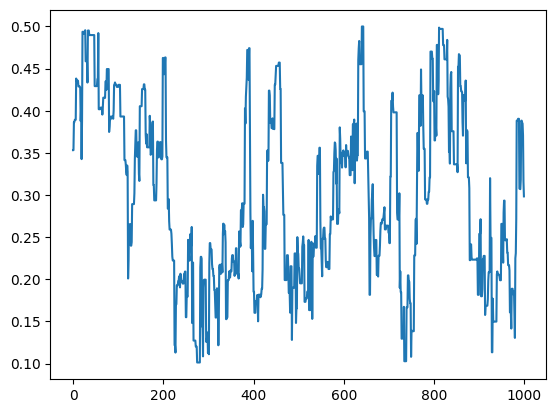

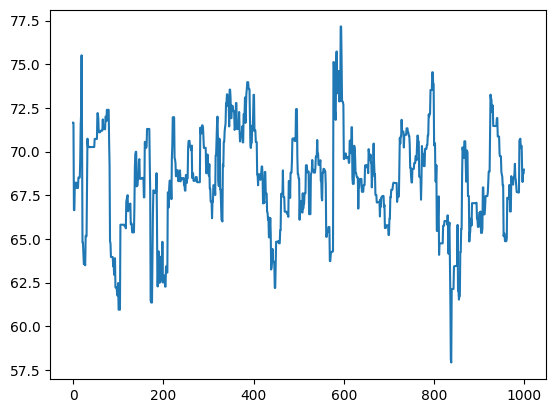

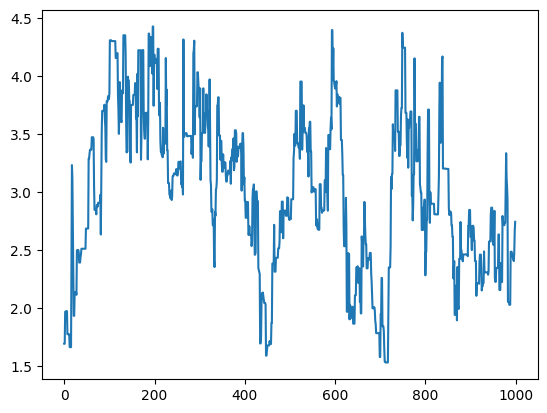

In [9]:
# just a quick check of a single walker
for i in range(3):
    plt.figure()
    plt.plot(chain[:, 0, i])

In [10]:
chain.shape # 1000 steps, 20 walkers, 3 parameters

(1000, 20, 3)

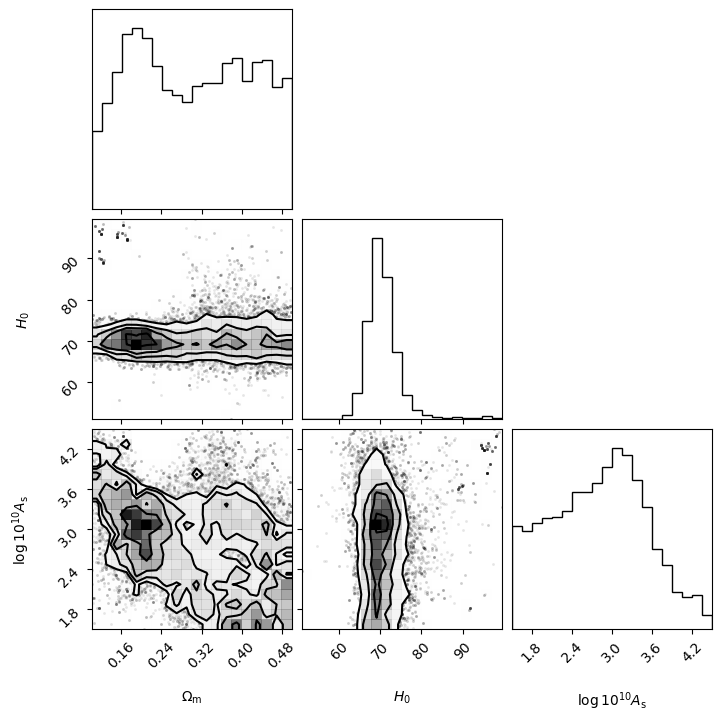

In [11]:
corner.corner(numpy.array(chain).reshape(-1, 3), labels=[r"$\Omega_{\rm m}$", "$H_0$", r"$\log 10^{10} A_{\rm{s}}$"] );